<a href="https://colab.research.google.com/github/GassnerChristoph/Code/blob/main/Fig1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=1XobbLRaWrPsWE1FHDcAFQWGz-CpIreDW
To: /content/data_backscatter_realistic_108particles_100ppm.csv
100%|██████████| 23.1M/23.1M [00:00<00:00, 67.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1I4-G6H5kvFTSR_BDoRZJxooL8v4CKT43
From (redirected): https://drive.google.com/uc?id=1I4-G6H5kvFTSR_BDoRZJxooL8v4CKT43&confirm=t&uuid=56dafe82-bc30-4227-b841-da820225695e
To: /content/data_transmission_108particles_100ppm.csv
100%|██████████| 2.16G/2.16G [00:16<00:00, 129MB/s]


Reading simulated data...
Done reading files (took 23.2 s)
Adding realistic energy resolution: 0.15 keV ...
Done adding energy resolution.


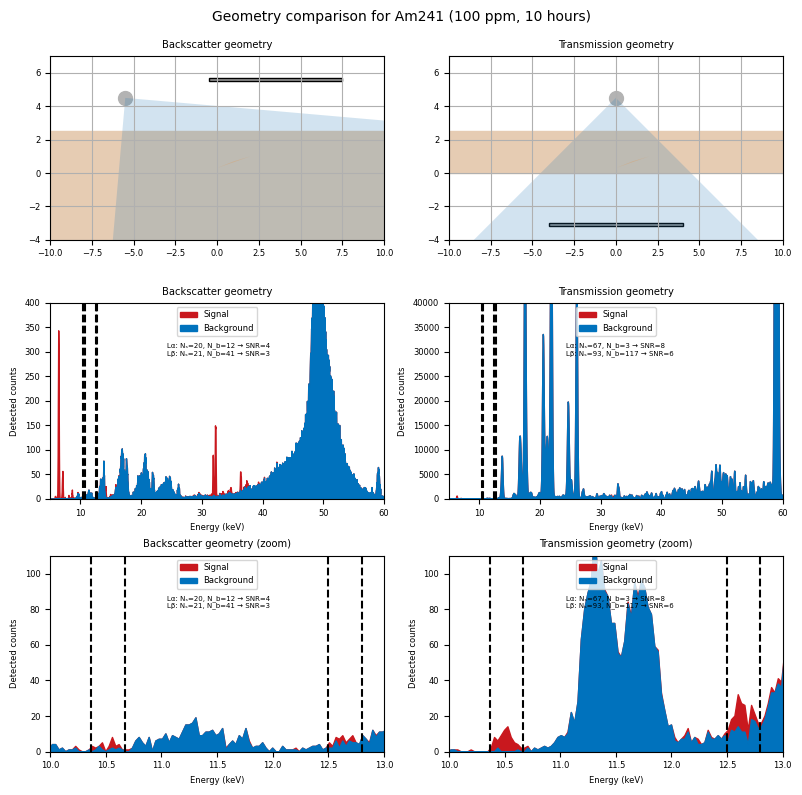

Figure exported to Fig1d.pdf


In [ ]:
!pip install -q gdown pandas numpy matplotlib
import gdown

id_backscatter = "1XobbLRaWrPsWE1FHDcAFQWGz-CpIreDW"
id_transmission = "1I4-G6H5kvFTSR_BDoRZJxooL8v4CKT43"
gdown.download(id=id_backscatter, output="data_backscatter_realistic_108particles_100ppm.csv", quiet=False)
gdown.download(id=id_transmission, output="data_transmission_108particles_100ppm.csv", quiet=False)

############################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time

# ============================================
#   Geometry comparison - Backscatter vs Transmission with Am-241
# ============================================

start_time = time()
print("Reading simulated data...")

# CSV-Dateien laden
data_b = pd.read_csv("data_backscatter_realistic_108particles_100ppm.csv")
data_t = pd.read_csv("data_transmission_108particles_100ppm.csv")

print(f"Done reading files (took {time() - start_time:.1f} s)")

# ============================================
#   Add energy resolution
# ============================================

FWHM_keV = 0.15  # [keV]
sigma = FWHM_keV / 2.355
rng = np.random.default_rng()

print(f"Adding realistic energy resolution: {FWHM_keV:.2f} keV ...")

# Energie (MeV → keV) + Gaußrauschen
data_b["E"] = data_b["Energy(MeV)"] * 1000.0 + sigma * rng.standard_normal(len(data_b))
data_t["E"] = data_t["Energy(MeV)"] * 1000.0 + sigma * rng.standard_normal(len(data_t))

print("Done adding energy resolution.")

# ============================================
#   Filter events (10 hours, cone geometry)
# ============================================

fluence = 995 * np.pi * 2 * (1 - np.cos(np.pi / 4))  # photons/s in 90° cone
N = 10 * 60 * 60 * fluence                           # photons in 10h

detector_area = 50.0  # mm²
detector_radius = np.sqrt(detector_area / np.pi)

for df in [data_b, data_t]:
    df["r_hit"] = np.sqrt(df["x(mm)"] ** 2 + df["y(mm)"] ** 2)

mask_b = (
    (data_b["EventID"] < N)
    & (data_b["Particle"] == "gamma")
    & (data_b["r_hit"] <= detector_radius)
)
mask_t = (
    (data_t["EventID"] < N)
    & (data_t["Particle"] == "gamma")
    & (data_t["r_hit"] <= detector_radius)
)

data_b = data_b[mask_b]
data_t = data_t[mask_t]

primary_b = data_b[data_b["Type"] == "Primary"]
secondary_b = data_b[data_b["Type"] == "Secondary"]

primary_t = data_t[data_t["Type"] == "Primary"]
secondary_t = data_t[data_t["Type"] == "Secondary"]

# ============================================
#   Histogram conversion
# ============================================

binwidth = 0.03  # [keV]
E = np.arange(0, 75 + binwidth, binwidth)

def hist(data):
    return np.histogram(data["E"], bins=np.append(E, E[-1] + binwidth))[0]

b = {
    "primary": hist(primary_b),
    "secondary": hist(secondary_b),
}
t = {
    "primary": hist(primary_t),
    "secondary": hist(secondary_t),
}

# ============================================
#   SNR calculation
# ============================================

peak = {
    "alpha": {"E": 10.52},
    "beta": {"E": 12.65},
}
peak_window = FWHM_keV

for name in ["alpha", "beta"]:
    mask = (E >= peak[name]["E"] - peak_window) & (E <= peak[name]["E"] + peak_window)
    peak[name]["window"] = mask

def calc_snr(hist_primary, hist_secondary, peak):
    Np = np.sum(hist_primary[peak])
    Ns = np.sum(hist_secondary[peak])
    SNR = Ns / np.sqrt(Ns + Np) if Ns + Np > 0 else 0
    return Np, Ns, SNR

for geom, d in zip(["b", "t"], [b, t]):
    for name in ["alpha", "beta"]:
        Np, Ns, SNR = calc_snr(d["primary"], d["secondary"], peak[name]["window"])
        d[name] = {"primary": Np, "secondary": Ns, "SNR": SNR}

# ============================================
#   Plotting
# ============================================

plt.rcParams.update({
    "font.size": 6,
    #"font.family": "Arial",
})

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Geometry comparison for Am241 (100 ppm, 10 hours)", fontsize=10)

# Geometry parameters
sample_thickness_transmission = 2.5  # mm
sample_thickness_backscatter = 25.0  # mm
sample_width = 20.0                  # mm
source_to_surface = 2.0
detector_to_surface = 3.0
detector_height = 0.2
detector_width = 8.0

xLimGeom = [-10, 10]
yLimGeom = [-4, 7]

# --- Backscatter geometry ---
ax = fig.add_subplot(3, 2, 1)
ax.set_title("Backscatter geometry")
sample_y = sample_thickness_transmission - sample_thickness_backscatter
ax.add_patch(Rectangle((-sample_width / 2, sample_y),
                       sample_width, sample_thickness_backscatter,
                       color=(0.9, 0.8, 0.7)))
source_x = -5.5
source_y = sample_y + sample_thickness_backscatter + source_to_surface
ax.scatter(source_x, source_y, s=100, color=(0.7, 0.7, 0.7))
detector_x = -0.5
detector_y = sample_y + sample_thickness_backscatter + detector_to_surface
ax.add_patch(Rectangle((detector_x, detector_y), detector_width, detector_height,
                       color=(0.6, 0.6, 0.6), ec="k"))
cone_len = 30
angles = np.deg2rad([-5, -95])
cone_x = [source_x, source_x + cone_len * np.cos(angles[0]), source_x + cone_len * np.cos(angles[1]), source_x]
cone_y = [source_y, source_y + cone_len * np.sin(angles[0]), source_y + cone_len * np.sin(angles[1]), source_y]
ax.fill(cone_x, cone_y, (0.3, 0.7, 1), alpha=0.2)
ax.set_xlim(xLimGeom)
ax.set_ylim(yLimGeom)
ax.set_aspect("equal", adjustable="box")
ax.grid(True, which="both")

# --- Transmission geometry ---
ax = fig.add_subplot(3, 2, 2)
ax.set_title("Transmission geometry")
ax.add_patch(Rectangle((-sample_width / 2, 0),
                       sample_width, sample_thickness_transmission,
                       color=(0.9, 0.8, 0.7)))
source_x = 0
source_y = sample_thickness_transmission + source_to_surface
ax.scatter(source_x, source_y, s=100, color=(0.7, 0.7, 0.7))
detector_y = -detector_to_surface - detector_height
ax.add_patch(Rectangle((source_x - detector_width / 2, detector_y),
                       detector_width, detector_height,
                       color=(0.6, 0.6, 0.6), ec="k"))
angles = np.deg2rad([-45, -135])
cone_x = [source_x,
          source_x + cone_len * np.cos(angles[0]),
          source_x + cone_len * np.cos(angles[1]),
          source_x]
cone_y = [source_y,
          source_y + cone_len * np.sin(angles[0]),
          source_y + cone_len * np.sin(angles[1]),
          source_y]
ax.fill(cone_x, cone_y, (0.3, 0.7, 1), alpha=0.2)
ax.set_xlim(xLimGeom)
ax.set_ylim(yLimGeom)
ax.set_aspect("equal", adjustable="box")
ax.grid(True, which="both")

# ============================================
#   Spectra (same layout as MATLAB)
# ============================================

def plot_spectrum(ax, E, primary, secondary, peak, xlim, ylim, title, data):
    ax.fill_between(E, primary + secondary, color=(0.7874, 0.093, 0.1196), label="Signal")
    ax.fill_between(E, primary, color=(0, 0.447, 0.741), label="Background")
    for name in ["alpha", "beta"]:
        ax.axvline(peak[name]["E"] - peak_window, color="k", ls="--")
        ax.axvline(peak[name]["E"] + peak_window, color="k", ls="--")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Detected counts")
    ax.legend(loc="upper center" if hasattr(ax, "legend") else "best")
    ax.set_title(title)
    subtitle = (
        f"Lα: Nₛ={int(data['alpha']['secondary'])}, N_b={int(data['alpha']['primary'])} → SNR={int(round(data['alpha']['SNR']))}\n"
        f"Lβ: Nₛ={int(data['beta']['secondary'])}, N_b={int(data['beta']['primary'])} → SNR={int(round(data['beta']['SNR']))}"
    )
    ax.text(0.35, 0.80, subtitle, transform=ax.transAxes, va="top", fontsize=5)
    ax.tick_params(direction="out")

# Full-scale spectra
plot_spectrum(fig.add_subplot(3, 2, 3), E, b["primary"], b["secondary"], peak,
              (5, 60), (0, 400), "Backscatter geometry", b)
plot_spectrum(fig.add_subplot(3, 2, 4), E, t["primary"], t["secondary"], peak,
              (5, 60), (0, 40000), "Transmission geometry", t)

# Zoomed spectra
plot_spectrum(fig.add_subplot(3, 2, 5), E, b["primary"], b["secondary"], peak,
              (10, 13), (0, 110), "Backscatter geometry (zoom)", b)
plot_spectrum(fig.add_subplot(3, 2, 6), E, t["primary"], t["secondary"], peak,
              (10, 13), (0, 110), "Transmission geometry (zoom)", t)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.savefig("Fig1d.pdf", bbox_inches="tight")
plt.show()
print("Figure exported to Fig1d.pdf")

